In [38]:
import numpy as np

def sigmoid(v, deriv=False):
  a = 1 / (1 + np.exp(-v))
  return a * (1 - a) if deriv else a

def relu(v, deriv=False):
  return np.where(v > 0, 1, 0) if deriv else np.maximum(0, v)

def linear(v, deriv=False):
  return np.ones(shape=v.shape) if deriv else v

activation_functions = {
    'sigmoid': sigmoid,
    'relu': relu,
    'linear': linear,
}

class NeuralNetwork():
  def __init__(self, layer_sizes, activation_funcs):
      # Take an array that contains the size of the layers to construct
      # Take an array that specifies the activation function to use at each layer
      self.num_layers = len(layer_sizes)
      self.activation_funcs = activation_funcs
      print(self.num_layers)
      print(len(self.activation_funcs))
      assert (self.num_layers-1) == len(self.activation_funcs)
      self.weights = []
      self.biases = []

      # Initialize the weights
      for p, c in zip(layer_sizes, layer_sizes[1:]):
            self.weights.append(np.random.randn(c, p) * 0.1)
            self.biases.append(np.zeros((c, 1)))

  def forward_propagation(self, A):
        # Store previous output from activations
        activations = [A]
        # Store pre activation vectors for backprop
        zs = []

        for W, b, actv in zip(self.weights, self.biases, self.activation_funcs):
            # Use matrix mult to perform forward pass
            Z = W @ A + b

            func = activation_functions[actv]
            A = func(Z)

            zs.append(Z)
            activations.append(A)

        return A, activations, zs

  def backward_propagation(self, X, Y, activations, zs):
        gradients_w = [np.zeros(w.shape) for w in self.weights]
        gradients_b = [np.zeros(b.shape) for b in self.biases]
        m = Y.shape[1]

        # Start with the output layer
        # Grab deriv from our current activation func
        delta = (activations[-1] - Y) * activation_functions[self.activation_funcs[-1]](zs[-1], True)

        # compute and apply respective gradients
        gradients_w[-1] = delta @ activations[-2].T / m
        gradients_b[-1] = np.sum(delta, axis=1, keepdims=True) / m

        # Loop through the rest of the layers in reverse order
        for l in reversed(range(1, self.num_layers-1)):
            func = activation_functions[self.activation_funcs[l-1]]
            delta = self.weights[l].T @ delta * func(zs[l-1], True)
            # compute and apply respective gradients
            gradients_w[l-1] = delta @ activations[l-1].T / m
            gradients_b[l-1] = np.sum(delta, axis=1, keepdims=True) / m

        return gradients_w, gradients_b


  def cost(self, A, Y):
    return np.mean((Y-A) ** 2)

  def train(self, X, Y, learning_rate=1e-3, iterations=10000):
    for j in range(iterations):
      A, activations, zs = self.forward_propagation(X)
      cost = self.cost(A, Y)
      gradients_w, gradients_b = self.backward_propagation(X, Y, activations, zs)

      # Update the parameters
      for i in range(len(self.weights)):
        # print(self.weights[i])
        # print(gradients_w[i])
        self.weights[i] -= learning_rate * gradients_w[i]
        self.biases[i] -= learning_rate * gradients_b[i]

      if (j % 10 == 0):
        print(f"Iteration {j} Cost: {cost}")

In [39]:
# here we do a simple test of the network to make sure that it works!
network = NeuralNetwork([2, 1], ["linear"])
print(network.weights)
print(network.biases)

print(network.forward_propagation(np.array([1, 1])))

X = np.array([[0, 1],[1, 0],[0,0], [1, 1], [2, 1], [5, 0]])
Y = np.array([[1], [1], [0], [2], [3], [5]])

network.train(X.T, Y.T, 1e-1, 50)

2
1
[array([[-0.02389839,  0.10204273]])]
[array([[0.]])]
(array([[0.07814434]]), [array([1, 1]), array([[0.07814434]])], [array([[0.07814434]])])
Iteration 0 Cost: 6.739148192889349
Iteration 10 Cost: 0.07980971338851052
Iteration 20 Cost: 0.05353875069487985
Iteration 30 Cost: 0.03871686753246355
Iteration 40 Cost: 0.028593128649960258


In [40]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X, Y = housing.data, housing.target

Y = Y.reshape(-1, 1)

# Split the dataset into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Split the data into a validation and training set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.10, random_state=42)

# scale features
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
X_val_scaled = scaler_X.transform(X_val)

scaler_Y = StandardScaler()
Y_train_scaled = scaler_Y.fit_transform(Y_train)
Y_test_scaled = scaler_Y.transform(Y_test)
Y_val_scaled = scaler_Y.transform(Y_val)

# Transpose dataset to match custom net
X_train_scaled = X_train_scaled.T
X_test_scaled = X_test_scaled.T
X_val_scaled = X_val_scaled.T

Y_train_scaled = Y_train_scaled.T
Y_test_scaled = Y_test_scaled.T
Y_val_scaled = Y_val_scaled.T

# Define the neural network with a suitable architecture for regression
layer_sizes = [X_train_scaled.shape[0], 64, 1]  # Input layer size, one hidden layer, and one output node for regression
activations = ["sigmoid", "linear"]
nn = NeuralNetwork(layer_sizes, activations)

# Train the neural network
nn.train(X_train_scaled, Y_train_scaled, learning_rate=.1, iterations=1000)

# Due to the verbose nature of the training output, let's only print the final cost to keep the output concise.
A, _, _ = nn.forward_propagation(X_val_scaled)
final_cost = nn.cost(A, Y_val_scaled)
print(f"Final val cost: {final_cost}")


3
2
Iteration 0 Cost: 1.1158584047269113
Iteration 10 Cost: 0.9152409890989719
Iteration 20 Cost: 0.8494521272511562
Iteration 30 Cost: 0.7842279533181584
Iteration 40 Cost: 0.7202075503024424
Iteration 50 Cost: 0.6600065676028697
Iteration 60 Cost: 0.6067094185371438
Iteration 70 Cost: 0.5625501187910601
Iteration 80 Cost: 0.5281936225782792
Iteration 90 Cost: 0.5028190879155888
Iteration 100 Cost: 0.4847256308407927
Iteration 110 Cost: 0.4720022915735264
Iteration 120 Cost: 0.46297041394701366
Iteration 130 Cost: 0.45635472985038195
Iteration 140 Cost: 0.4512744071803617
Iteration 150 Cost: 0.44715853960475893
Iteration 160 Cost: 0.4436520132488706
Iteration 170 Cost: 0.4405392077394301
Iteration 180 Cost: 0.43769059942382343
Iteration 190 Cost: 0.4350283908221314
Iteration 200 Cost: 0.4325054699960142
Iteration 210 Cost: 0.43009287609825175
Iteration 220 Cost: 0.42777239070390954
Iteration 230 Cost: 0.42553214376531734
Iteration 240 Cost: 0.42336402437433107
Iteration 250 Cost: 0.42

Now that we've built and tested our homemade network, we can start part 2, and do some EDA.

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the California Housing dataset
housing = fetch_california_housing()

# Convert the dataset into a DataFrame for easier EDA
df = pd.DataFrame(data=housing.data, columns=housing.feature_names)
df['MedHouseVal'] = housing.target  # Target variable: median house value

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


Here we can see that there are no null values that we need to handle. Lets take a deeper look and see if any values seem incorrect

In [42]:

# Display the first few rows of the DataFrame
print(df.head())

# Basic statistical summary
print("\nStatistical Summary:")
print(df.describe())



   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseVal  
0    -122.23        4.526  
1    -122.22        3.585  
2    -122.24        3.521  
3    -122.25        3.413  
4    -122.25        3.422  

Statistical Summary:
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000    

It seems like there are no rediculous mins or maximums. Lets take a look at the distributions of the data.

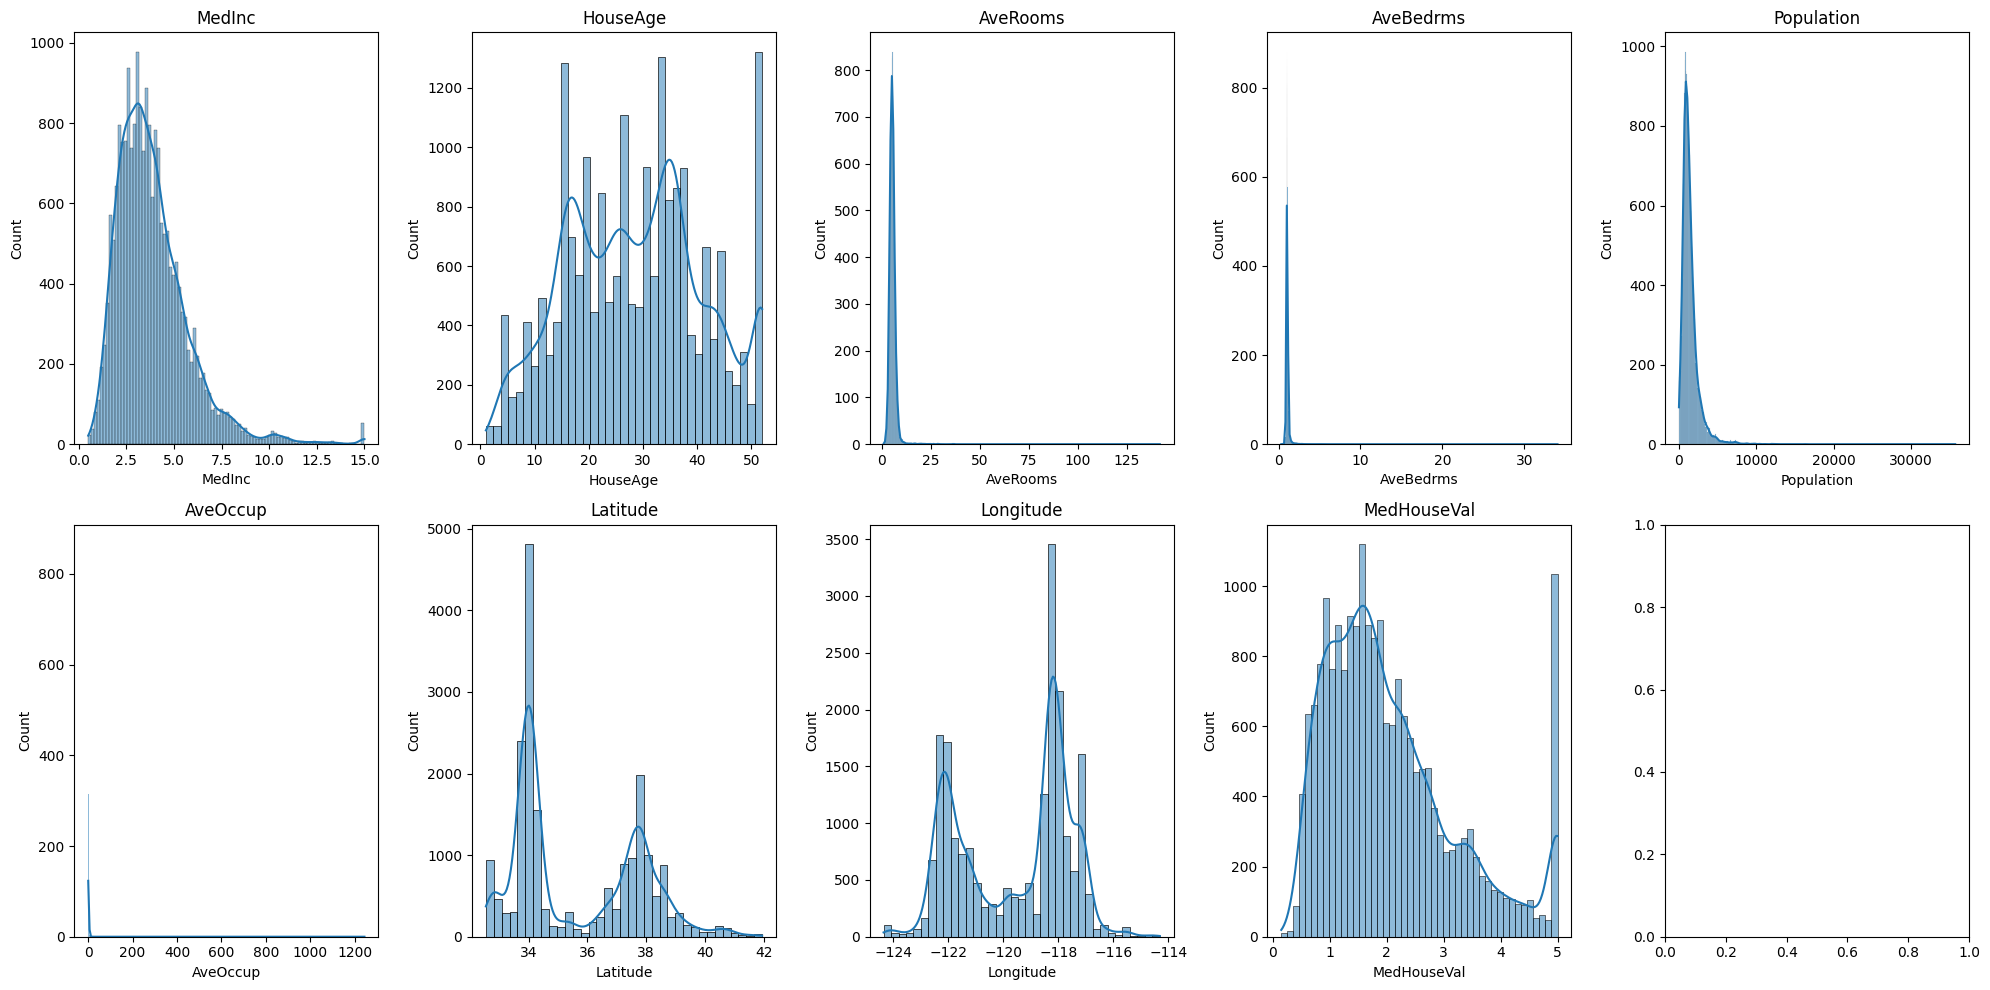

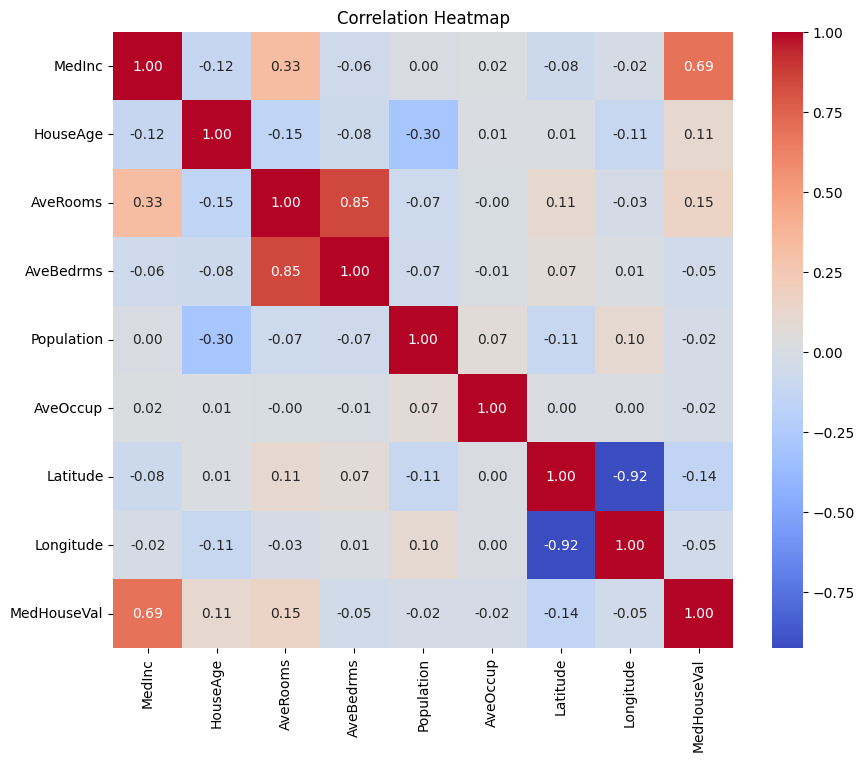

In [43]:

# Plotting distributions of features and target variable
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
axs = axs.flatten()
for i, col_name in enumerate(df.columns):
    sns.histplot(df[col_name], kde=True, ax=axs[i])
    axs[i].set_title(col_name)
plt.tight_layout()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap")

plt.show()

While some of the values do seem to have long tails, this is to be expected with the nature of income and house features. I do not think that this requires any feature engineering for a nonlinear model like a NN, so I think that we can leave the data as is. We see some pretty good correlations here such as Ave Rooms, but others like lat and longitude are a little smaller than we'd expect. This is probably because it is a nonlinear relationship, but that should be fine for a NN. If we were using linear regression, I would probably try to do feature engineering and create some features such as distance from big cities.

When researching how to implement the model in keras, I used the provided link: https://www.tensorflow.org/api_docs/python/tf/GradientTape

I also referenced this article: https://medium.com/mlearning-ai/tensorflow-gradient-tape-mnist-536c47fb8d85

In [44]:
import tensorflow as tf

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X, Y = housing.data, housing.target

Y = Y.reshape(-1, 1)

# Split the dataset into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Split the data into a validation and training set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.10, random_state=42)

# scale features
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
X_val_scaled = scaler_X.transform(X_val)

scaler_Y = StandardScaler()
Y_train_scaled = scaler_Y.fit_transform(Y_train)
Y_test_scaled = scaler_Y.transform(Y_test)
Y_val_scaled = scaler_Y.transform(Y_val)

# Convert the training and test data to TensorFlow tensors
X_train_scaled_tf = tf.convert_to_tensor(X_train_scaled, dtype=tf.float32)
y_train_scaled_tf = tf.convert_to_tensor(Y_train_scaled, dtype=tf.float32)
X_test_scaled_tf = tf.convert_to_tensor(X_test_scaled, dtype=tf.float32)
y_test_scaled_tf = tf.convert_to_tensor(Y_test_scaled, dtype=tf.float32)
X_val_scaled_tf = tf.convert_to_tensor(X_val_scaled, dtype=tf.float32)
y_val_scaled_tf = tf.convert_to_tensor(Y_val_scaled, dtype=tf.float32)

# Define the model architecture
model = Sequential([
    # I expirimented with a few other activation functions, but found the best results with sigmoid
    Dense(64, activation='sigmoid', input_shape=(X_train_scaled.shape[1],)),
    Dense(1, activation='linear', )
])

optimizer = tf.optimizers.Adam(learning_rate=0.01)
loss_fn = tf.losses.MeanSquaredError()

def train_step(model, inputs, outputs, loss_fn, optimizer):
    #we can use gradient tape to keep track of the gradient information during the forward pass
    with tf.GradientTape() as tape:
        # Create forward pass
        predictions = model(inputs, training=True)
        # Compute loss
        loss = loss_fn(outputs, predictions)
    # Use gradient tape to get gradient
    gradients = tape.gradient(loss, model.trainable_variables)
    # Apply gradient
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss


# Run the training loop
epochs = 1000
for epoch in range(epochs):
    loss = train_step(model, X_train_scaled_tf, y_train_scaled_tf, loss_fn, optimizer)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy()}")

# Evaluate the model on the test set
predictions = model(X_val_scaled_tf, training=False)
test_loss = loss_fn(y_val_scaled_tf, predictions)
print(f"Final val loss: {test_loss.numpy()}")


Epoch 0, Loss: 1.0722088813781738
Epoch 100, Loss: 0.3369367718696594
Epoch 200, Loss: 0.3201395273208618
Epoch 300, Loss: 0.29590708017349243
Epoch 400, Loss: 0.27743420004844666
Epoch 500, Loss: 0.2613992989063263
Epoch 600, Loss: 0.24735473096370697
Epoch 700, Loss: 0.23647750914096832
Epoch 800, Loss: 0.22787262499332428
Epoch 900, Loss: 0.22175319492816925
Final val loss: 0.24292905628681183


I got the best validation loss using essentially the same network. I found the best results using  I tried created a more complex or more layered network, but I just started to get overfitting. I added Both L1 and L2 regularization, but then the loss essentially returned to what it was before. I don't think the correlations are complicated enough to need a deeper network, and a validation loss of .238 is about the best that we could hope for. The model performs significantly better when the inputs are normalized, this is probably because of how the sigmoid activation function works. It may have worked better with non normalized inputs had I stuck with the relu activation function.

In [45]:
predictions = model(X_test_scaled_tf, training=False)
test_loss = loss_fn(y_test_scaled_tf, predictions)
print(f"Final val loss: {test_loss.numpy()}")

Final val loss: 0.23883071541786194


Here we can see that we have a training loss of .23, which is quite good for this task! We confirm that the model does indeed work :)